In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf

d:\python 3.12\Lib\site-packages\pandas\core\indexes\base.py:7616: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


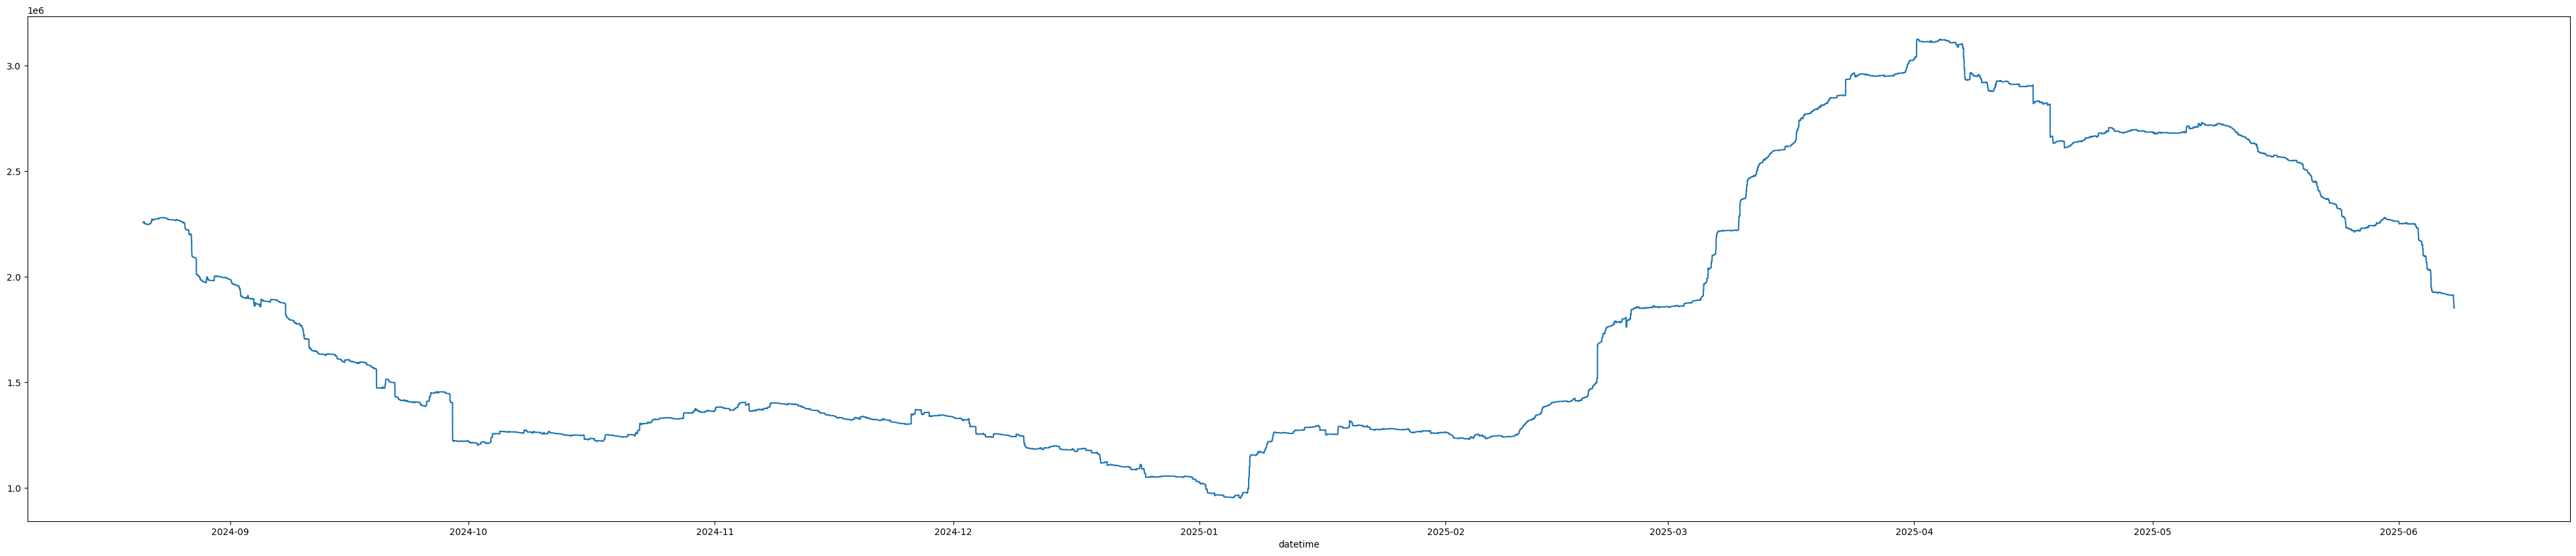

In [24]:
df = pd.read_csv('./data/BTC factors/supply/BTC_10m_active_3m_6m.csv')
start_time = '2024-08-21 00:00:00'
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.set_index(df.columns[0], inplace=True)
df = df[start_time:]
plt.figure(figsize=(50,10))
plt.plot(df)
plt.xlabel('datetime')
plt.show()

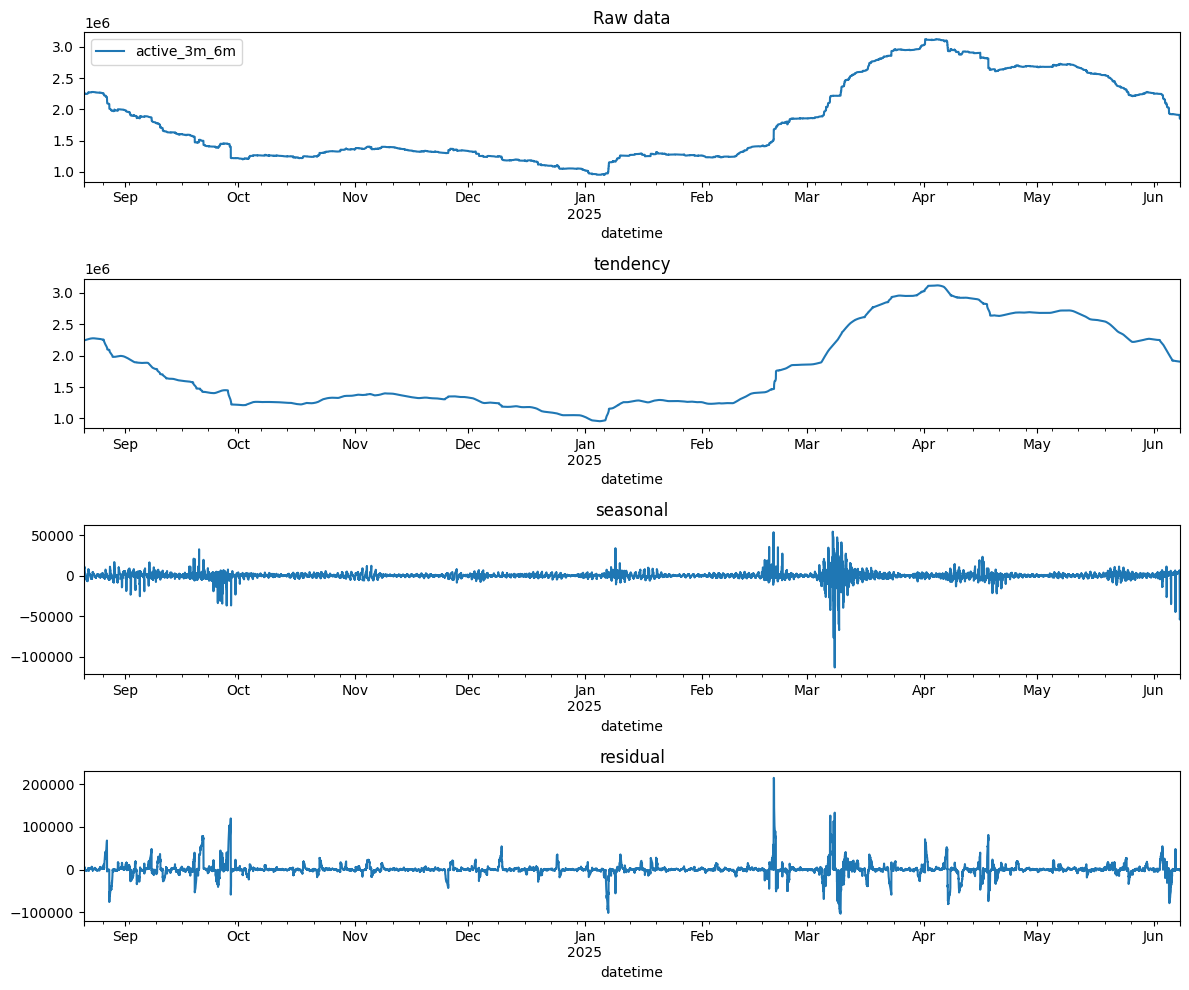

In [25]:
from statsmodels.tsa.seasonal import STL
stl = STL(df, period=168, 
            robust=True)
result_F = stl.fit()
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
result_F.observed.plot(ax=axes[0], title='Raw data')
result_F.trend.plot(ax=axes[1], title='tendency')
result_F.seasonal.plot(ax=axes[2], title='seasonal')
result_F.resid.plot(ax=axes[3], title='residual')
plt.tight_layout()
plt.show()

Check the stationary

In [26]:
## ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -0.7765976007505899
p-value: 0.8258998844063592


Therfore I gonnna use differencing or using transformation

In [27]:
data= df.diff().dropna()
result_diff = adfuller(data.dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic: -23.178247652343835
p-value: 0.0


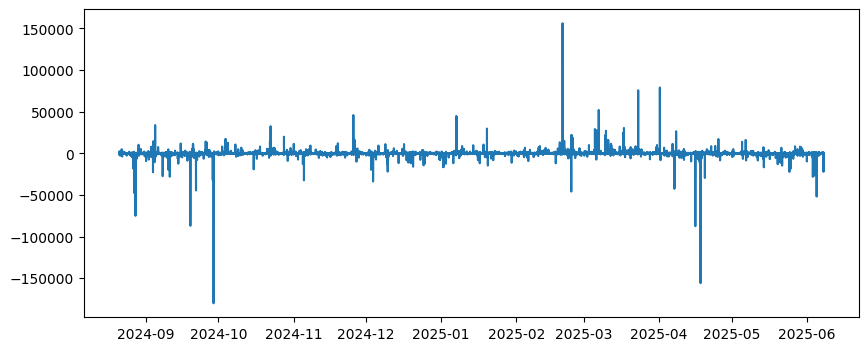

In [28]:
data = data.dropna()
plt.figure(figsize=(10,4))
plt.plot(data)
plt.show()

The time series is now stationary after logarithm, so we are going to use Seasonal decomposition.

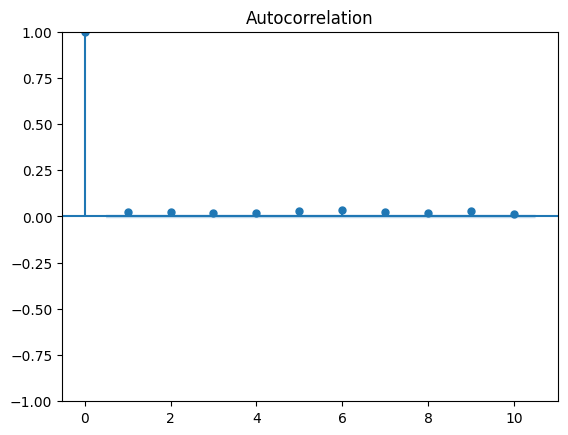

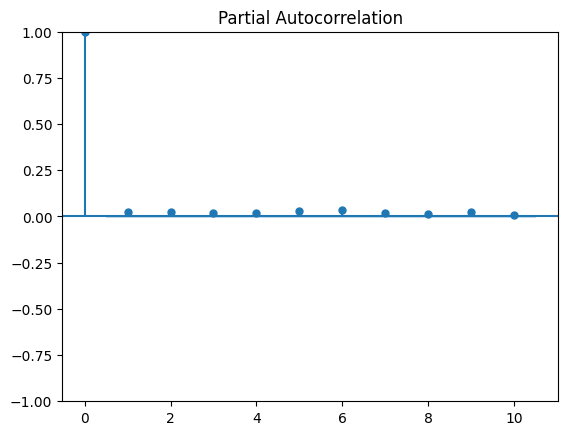

In [29]:
# check the residual is normally distributed 
acffig = plot_acf(data,lags =10, alpha=0.05)
pacffig = plot_pacf(data,lags=10,alpha=0.05)

Train Test split

In [30]:
split = int(len(data) * 0.8)
train_data = data.iloc[:split]
test_data = data.iloc[split:]

It shows that the data is suitable for using ARMA(1,1) model. But in this part, I only talk about MA

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data,order=(0,0,1)).fit(disp=False)

d:\python 3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
d:\python 3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


⚠ Residual autocorrelation remains.
18.07178789869861


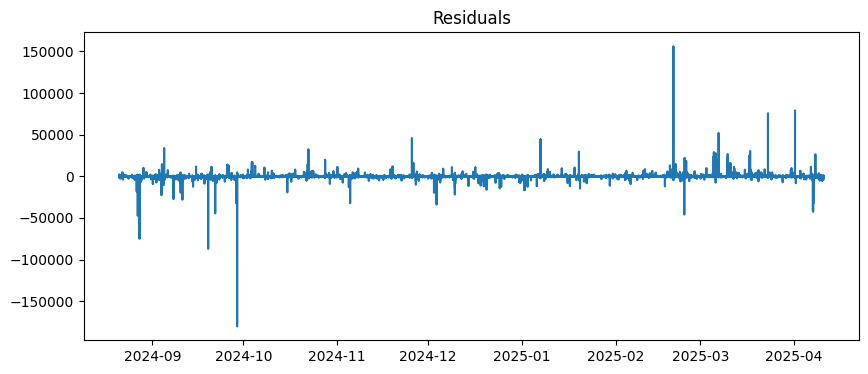

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residual = model.resid
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.title("Residuals")

lb = acorr_ljungbox(residual, lags=[10], return_df=True)
p = lb['lb_pvalue'].iloc[0]
if p < 0.05:
    print("⚠ Residual autocorrelation remains.")
else:
    print("✅ Residuals white-noise-like.")
print(sum(residual)/len(residual))  

Prediction

C:\Users\caiyx\AppData\Local\Temp\ipykernel_16456\1326827541.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred[0] +=df.iloc[-nsteps][0]
C:\Users\caiyx\AppData\Local\Temp\ipykernel_16456\1326827541.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  pred[0] +=df.iloc[-nsteps][0]
C:\Users\caiyx\AppData\Local\Temp\ipykernel_16456\1326827541.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred[i] += pred[i-1]
C:\Users\ca

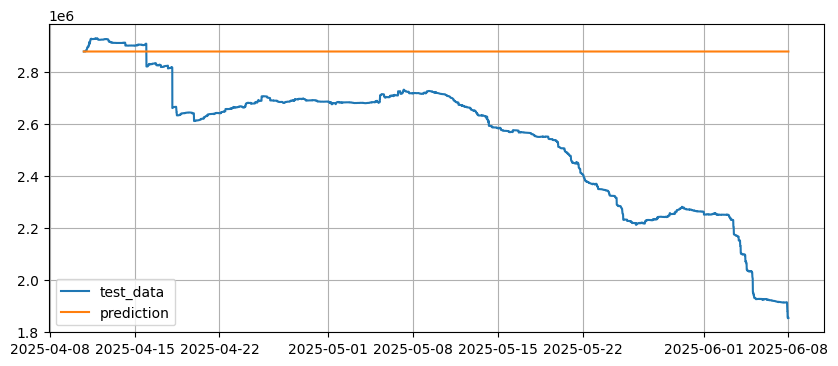

In [ ]:
nsteps = len(test_data)
pred = model.forecast(nsteps)
pred[0] +=df.iloc[-nsteps][0]
for i in range(1,len(pred)):
    pred[i] += pred[i-1]   # 返回到差分前的尺度
plt.figure(figsize=(10,4))
plt.plot(df[-nsteps:],label = 'test_data')
plt.plot(pred,label='prediction')
plt.grid()
plt.legend()
plt.show()

In [45]:
prediction_data_value = df['active_3m_6m'][-nsteps:]
MSE = np.mean((pred-prediction_data_value)**2)
MAE = np.mean(abs(pred-prediction_data_value))
print('MSE:',MSE)
print('MAE:',MAE)

MSE: 176508613344.9359
MAE: 339090.81780512584


Very bad prediction